In [229]:
# 모듈 호출
from tensorflow import keras

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchinfo import summary
from torchmetrics.functional.regression import r2_score
from torchmetrics.functional.classification import f1_score

In [230]:
# 데이터 불러오기
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

In [231]:
# 데이터 확인
print(train_input.shape, type(train_input))
print(test_input.shape, type(test_input))

(60000, 28, 28) <class 'numpy.ndarray'>
(10000, 28, 28) <class 'numpy.ndarray'>


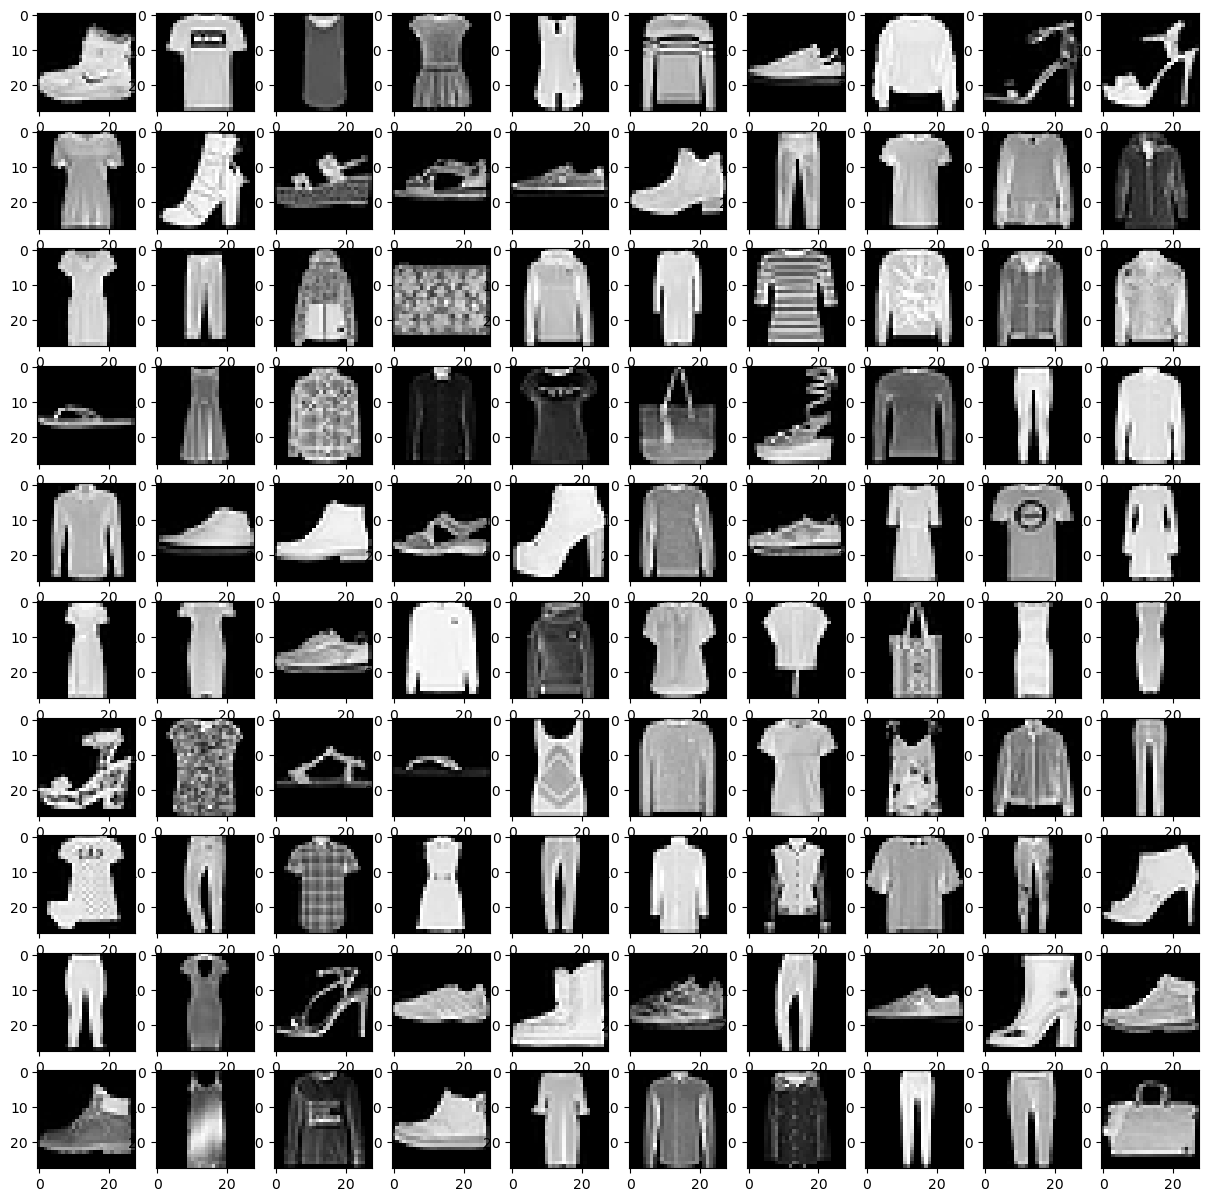

In [232]:
# 시각화
fig, axs = plt.subplots(10,10,figsize=(15,15))
for i in range(10):
    for j in range(10):
        axs[i][j].imshow(train_input[i*10+j], cmap='gray')
plt.show()

In [233]:
# 데이터 변환 (array => DataFrame)
train_inputDF = pd.DataFrame(train_input.copy().reshape(60000,-1))
train_targetDF = pd.DataFrame(train_target.copy())
test_inputDF = pd.DataFrame(test_input.copy().reshape(10000,-1))
test_targetDF = pd.DataFrame(test_target.copy())

train_inputDF.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,119,114,130,76,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,22,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,33,96,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [234]:
# 데이터셋 생성 클래스
class MakeDataset(Dataset):
    def __init__(self, featureDF, targetDF):
        super().__init__()
        self.featureDF = featureDF
        self.targetDF = targetDF
        self.n_rows = featureDF.shape[0]
        self.n_features = featureDF.shape[1]

    def __len__(self):
        return self.n_rows
    
    # Dataset 클래스의 __getitem__이 매개변수로 self, index를 받음
    def __getitem__(self, idx): # 인덱스를 받아 값을 보여주는 역할을 하는듯
        # torch.FloatTensor는 값을 array형태로 받음 (values를 쓰는 이유)
        featureTS = torch.FloatTensor(self.featureDF.iloc[idx].values)
        targetTS = torch.FloatTensor(self.targetDF.iloc[idx].values)
        return featureTS, targetTS

In [235]:
trainDS = MakeDataset(train_inputDF, train_targetDF)
testDS = MakeDataset(test_inputDF, test_targetDF)
trainDS.__getitem__(0) # 0번째 인덱스의 피쳐, 타겟 텐서를 가져옴

(tensor([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           1.,   0.,   0.,  13.,  73.,   0.,   0.,   1.,   4.,   0.,   0.,   0.,
           0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   3.,   0.,  36., 136., 127.,  62.,  54.,   0.,
           0.,   0.,   1.,   3.,   4.,   0.,   0.,   3.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,  

In [236]:
print(f"trainDS : {trainDS.n_rows, trainDS.n_features}")
print(f"testDS : {testDS.n_rows, testDS.n_features}")

trainDL = DataLoader(trainDS, batch_size=32)
testDL = DataLoader(testDS, batch_size=32)

trainDS : (60000, 784)
testDS : (10000, 784)


In [237]:
# 모델 인스턴스 생성 클래스
class MakeModel(nn.Module):
    def __init__(self, input_in, output_out, model_type, act_func, hidden_list):
        super().__init__()

        # 입력층
        self.input_layer = nn.Linear(input_in, hidden_list[0])
        # 은닉층
        self.hidden_layer_list = nn.ModuleList()
        for i in range(len(hidden_list)-1):
            self.hidden_layer_list.append(nn.Linear(hidden_list[i], hidden_list[i+1]))
        # 출력층
        self.output_layer = nn.Linear(hidden_list[-1], output_out)

        self.model_type = model_type
        self.act_func = act_func

    # forward는 콜백 메서드 (예측값 pred_y를 생성하는 용도)
    # 나중에 모델 학습할때 x자리에 X_batch 형태로 데이터가 들어옴
    def forward(self, x):
        # 입력층
        x = self.input_layer(x)
        x = self.act_func(x)

        # 은닉층
        for i in self.hidden_layer_list:
            x = i(x)
            x = self.act_func(x)

        # 출력층
        if self.model_type == 'regression' or self.model_type == 'multiclass':
            return self.output_layer(x)
        elif self.model_type == 'binary':
            x = self.output_layer(x)
            return F.sigmoid(self.output_layer(x))

In [238]:
model = MakeModel(input_in=784, output_out=10, model_type='multiclass',
                  act_func=F.relu, hidden_list=[100,80,60,40,20])

print(model)
summary(model)

MakeModel(
  (input_layer): Linear(in_features=784, out_features=100, bias=True)
  (hidden_layer_list): ModuleList(
    (0): Linear(in_features=100, out_features=80, bias=True)
    (1): Linear(in_features=80, out_features=60, bias=True)
    (2): Linear(in_features=60, out_features=40, bias=True)
    (3): Linear(in_features=40, out_features=20, bias=True)
  )
  (output_layer): Linear(in_features=20, out_features=10, bias=True)
)


Layer (type:depth-idx)                   Param #
MakeModel                                --
├─Linear: 1-1                            78,500
├─ModuleList: 1-2                        --
│    └─Linear: 2-1                       8,080
│    └─Linear: 2-2                       4,860
│    └─Linear: 2-3                       2,440
│    └─Linear: 2-4                       820
├─Linear: 1-3                            210
Total params: 94,910
Trainable params: 94,910
Non-trainable params: 0

In [239]:
# 검증 함수
def testing(testDL, model):
    model.eval() # 검증 모드임을 명시적으로 선언

    one_epoch_test_loss  = 0
    one_epoch_test_score = 0

    with torch.no_grad():
        for X_batch, y_batch in testDL:

            pred_test_y = model(X_batch)

            y_batch1D = y_batch.reshape(-1)
            loss_test = F.cross_entropy(pred_test_y, y_batch1D.long())
            pred_test_y_label = torch.argmax(pred_test_y, dim=1)
            score_test = f1_score(pred_test_y_label, y_batch1D,
                                  task='multiclass', num_classes=10)
            
            one_epoch_test_loss += loss_test.item()
            one_epoch_test_score += score_test.item()

    loss_test_avg = one_epoch_test_loss / len(testDL)
    score_test_avg = one_epoch_test_score / len(testDL)
    return loss_test_avg, score_test_avg

In [240]:
# 훈련 함수
def training(trainDL, testDL, model, epoch, optimizer):
    model.train() # 학습 모드임을 명시적으로 선언

    total_train_loss_list = []
    total_train_score_list = []
    total_test_loss_list = []
    total_test_score_list = []

    for i in range(1, epoch+1):

        one_epoch_train_loss = 0
        one_epoch_train_score = 0

        for X_batch, y_batch in trainDL:
            pred_train_y = model(X_batch)
            y_batch1D = y_batch.reshape(-1)
            loss_train = F.cross_entropy(pred_train_y, y_batch1D.long())
            pred_train_y_label = torch.argmax(pred_train_y, dim=1)
            score_train = f1_score(pred_train_y_label, y_batch1D,
                                task='multiclass', num_classes=10)
            
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            
            one_epoch_train_loss += loss_train.item()
            one_epoch_train_score += score_train.item()

        loss_train_avg = one_epoch_train_loss/len(trainDL)
        score_train_avg = one_epoch_train_score/len(trainDL)
        total_train_loss_list.append(loss_train_avg)
        total_train_score_list.append(score_train_avg)

        loss_test_avg, score_test_avg = testing(testDL, model)

        total_test_loss_list.append(loss_test_avg)
        total_test_score_list.append(score_test_avg)

        print(f"[Loss : {i}/{epoch}] Train : {loss_train_avg:.4f}, Test : {loss_test_avg:.4f}")
        print(f"[Score : {i}/{epoch}] Train : {score_train_avg:.4f}, Test : {score_test_avg:.4f}")

    return total_train_loss_list, total_test_loss_list, total_train_score_list, total_test_score_list

In [241]:
# 옵티마이저
adam_optim = optim.Adam(model.parameters(), lr = 0.00001)

EPOCH = 1
# from TorchTrainTest import training, testing
result = training(trainDL, testDL, model, epoch=EPOCH,
                  optimizer=adam_optim)
# result = training(trainDL, testDL, model, adam_optim, EPOCH,
#                   is_reg=False, is_bin=False, num_classes=10)

[Loss : 1/1] Train : 1.1556, Test : 0.7259
[Score : 1/1] Train : 0.6283, Test : 0.7636
